### Table Of Contents:
    Section 0: Initializing our notebook
        0.0: Statement
        0.1: Importing Packages
    Section 1: Data
        1.0: Loading Data
        1.1: Preprocessing Data pt. 1
        1.2: Data Visualization
        1.3: Preprocessing Data pt. 2
    Section 2: Dimensionality Reduction


## 0.0: Statement
(Also in README.md)

In this project, we will analyze how different variables can affect the salary of an individual. We will then build Binary classifiers of increasing levels of complexity, ending with a stack of classifiers ending with a Neural Net. The first goal is to create an understanding of the circumstances in one's life that will correlate with a higher probability for him or her, of receiving a greater than $50,000 annual salary. The second goal, is to analyze how various models perform in terms of precision, recall, accuracy, and occasionaly the AUC curve.

## 0.1 Importing Packages
We will be importing the following. I will turn off FutureWarnings to make the notebook cleaner

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, roc_curve, recall_score, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC, LinearSVC #O(m**2.3 x n), O(mxn )
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, StackingClassifier 
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
### 1.0 Loading Data
I download the data from Kaggle:

https://www.kaggle.com/lodetomasi1995/income-classification

Limited information about the data can be found there

In [3]:
df=pd.read_csv('income_evaluation.csv')
df.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K


## 1.1 Preprocessing Data pt.1

In [4]:
df.columns

Index(['age', ' workclass', ' fnlwgt', ' education', ' education-num',
       ' marital-status', ' occupation', ' relationship', ' race', ' sex',
       ' capital-gain', ' capital-loss', ' hours-per-week', ' native-country',
       ' income'],
      dtype='object')

As you can tell, many columns start with a space. Let's rename the columns by splitting the names with a space

In [9]:
[df.rename(columns={col: col.split(' ')[-1]}, inplace=True) for col in df.columns]
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object')

Next, we create a boolean target set (' >50K':True, ' <=50K':False)

In [11]:
y_train=df['income']
y_train=y_train==' >50K'
X_train=df.drop(['income'], axis=1)

We will use k-fold cross validation for most classifiers, but will leave a hold-out test set nonetheless

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, stratify=y_train, test_size=.15, random_state=41)
#Let's reset the index for every set:
[set_df.reset_index(drop=True, inplace=True) for set_df in [X_train, X_test, y_train, y_test]]

Let's take a look at whether or not we have to deal with missing data:

In [21]:
X_train.isnull().sum().sum()

0

Apparently not! Let's check to see what kinds of objects we will be dealing with:

In [8]:
X_train.info(verbose=True, null_counts=True) #Test set has no nulls as well

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27676 entries, 0 to 27675
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             27676 non-null  int64 
 1   workclass       27676 non-null  object
 2   fnlwgt          27676 non-null  int64 
 3   education       27676 non-null  object
 4   education-num   27676 non-null  int64 
 5   marital-status  27676 non-null  object
 6   occupation      27676 non-null  object
 7   relationship    27676 non-null  object
 8   race            27676 non-null  object
 9   sex             27676 non-null  object
 10  capital-gain    27676 non-null  int64 
 11  capital-loss    27676 non-null  int64 
 12  hours-per-week  27676 non-null  int64 
 13  native-country  27676 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.0+ MB


It's a mixture between strings and numbers, so we will have to do more data processing

In [22]:
X_train.iloc[:3,:]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,59,?,160662,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,2407,0,60,United-States
1,50,Private,209320,Bachelors,13,Married-civ-spouse,Sales,Husband,White,Male,0,0,40,United-States
2,47,Local-gov,228372,Masters,14,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,48,United-States


In [7]:
y_train[:3]

0    False
1     True
2     True
Name: income, dtype: bool

## 1.3 Data Visualization Numerical variables
Before we encode our categorical variables, let's take a look at them first:

Only 24% of our training data consists of >50K$ instances, so we will likely struggle with acheiving a good recall score but will likely get good accuracy scores.

In [13]:
round(sum(y_train)/len(y_train),2)

0.24

Let's keep a list of the object columns, and a separate list of the number columns, just in case:

In [14]:
list_nums=[column for column in X_train.columns if X_train[column].dtype==np.dtype('int')]
list_objs=[column for column in X_train.columns if X_train[column].dtype==np.dtype('O')]

I will create a temporary dataframe to make the analysis easier

In [15]:
df_temp=pd.merge(X_train, y_train, right_index=True, left_index=True)

Of particular interest to us in the numerical analysis, will be the education-num, age, and hours per week worked. fnlwgt seems to have absolutely no correlation with any other feature, so it appears to be random (and useless)

<AxesSubplot:>

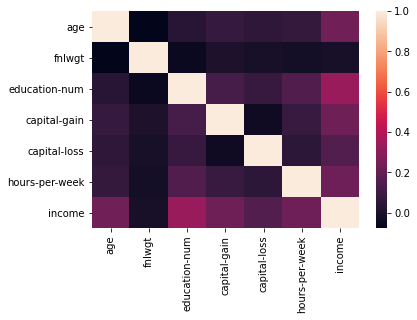

In [16]:
corr_num=df_temp.corr()
sns.heatmap(corr_num)

### Age:

The age is right-skewed (-1 year olds can't hold a job, for one)

The mean age of the study participant was 38 years, and the standard deviation was 13.6

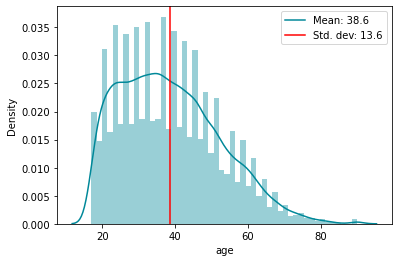

In [26]:
sns.distplot(X_train['age'], color='#008899')
plt.axvline(X_train['age'].mean(), 0, 1, color='red')
mean=round(X_train['age'].mean(),1)
std_deviation=round(X_train['age'].std(),1)
plt.legend(labels=["Mean: {}".format(mean), "Std. dev: {}".format(std_deviation)])

Remember that a salary higher than $50K is equivalent to True, in our dataset.
As you may have already guessed, a >50K salary is correlated to a higher age, considering the median and IQR.

<AxesSubplot:xlabel='income', ylabel='age'>

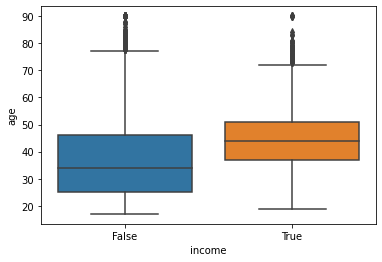

In [25]:
sns.boxplot(x='income', y='age', data=df_temp)

### Hours per week worked:

Let's examine how the frequency distribution of how many hours people worked per week:

Text(0.5, 1.0, 'Hours per week Frequency Dist.')

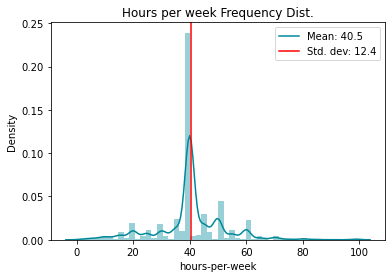

In [27]:
sns.distplot(X_train['hours-per-week'], color='#008899')
plt.axvline(X_train['hours-per-week'].mean(), 0, 1, color='red')
mean=round(X_train['hours-per-week'].mean(),1)
std_deviation=round(X_train['hours-per-week'].std(),1)
plt.legend(labels=["Mean: {}".format(mean), "Std. dev: {}".format(std_deviation)])
plt.title('Hours per week Frequency Dist.')

All we can tell is that the vast majority of those sampled, work about 40 hours per week, with some working less/more. What is interesting, is that there are gaps between the hours worked. Perhaps this implies a bias in people's memory (estimating in terms of 5s/10s is easier), or more companies are willing to make someone work h hours such that h%5=0, or both!

<AxesSubplot:xlabel='income', ylabel='hours-per-week'>

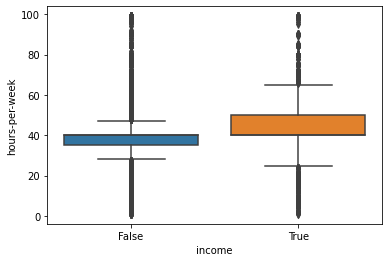

In [28]:
sns.boxplot(x='income', y='hours-per-week', data=df_temp)

It appears that making more money is in fact correlated to working for more hours

### Education number of years:

Text(0.5, 1.0, 'Density function of number of years of education')

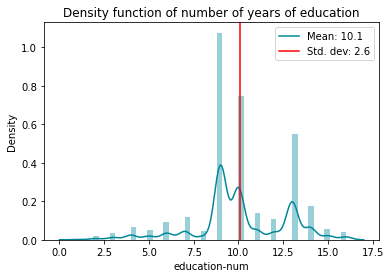

In [30]:
sns.distplot(X_train['education-num'], color='#008899')
plt.axvline(X_train['education-num'].mean(), 0, 1, color='red')
mean=round(X_train['education-num'].mean(),1)
std_deviation=round(X_train['education-num'].std(),1)
plt.legend(labels=["Mean: {}".format(mean), "Std. dev: {}".format(std_deviation)])
plt.title('Density function of number of years of education')

In [32]:
min(X_train['age'])

17

This is quite challenging to interpret soleley because I do not have more details of how this feature's data was gathered. Given that the minimum age implies that children were not asked, I'm not sure why this data is in general, low. Nonetheless, let's continue, to see how the differences in education length, correlate to a higher income:

<AxesSubplot:xlabel='income', ylabel='education-num'>

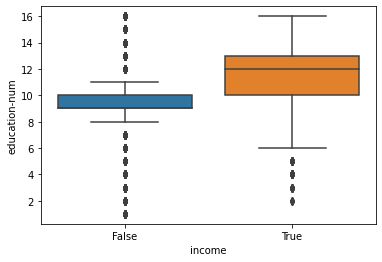

In [33]:
sns.boxplot(x='income', y='education-num', data=df_temp)

## 1.4 Data Visualization Categorical variables

Text(0.5, 1.0, 'Occupation')

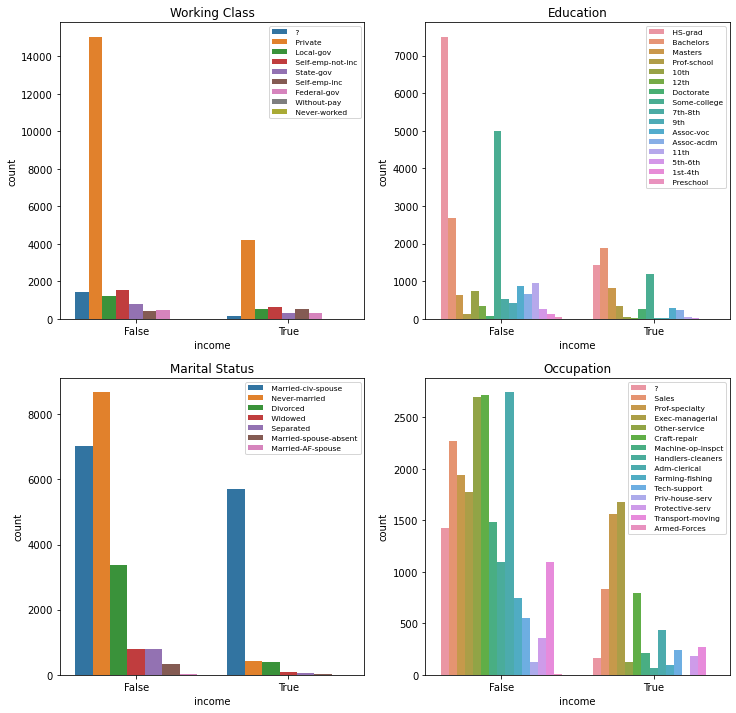

In [39]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
plot1=sns.countplot(x='income', hue='workclass', data=df_temp, ax=ax[0,0])
plot1.legend(loc='upper right',fontsize = 7.5)
plot1.set_title('Working Class')
plot2=sns.countplot(x='income', hue='education', data=df_temp, ax=ax[0,1])
plot2.legend(fontsize = 7.5, loc='upper right')
plot2.set_title('Education')
plot3=sns.countplot(x='income', hue='marital-status', data=df_temp, ax=ax[1,0])
plot3.legend(loc='upper right', fontsize = 7.5)
plot3.set_title('Marital Status')
plot4=sns.countplot(x='income', hue='occupation', data=df_temp, ax=ax[1,1])
plot4.legend(fontsize = 7.5, loc='upper right')
plot4.set_title('Occupation')

It's clear that the vast majority of the people in this set are grouped into 'private'. It looks like Self-emp-inc (self employed in a business) have an advantage, but we will analyze the correlation later after One hot encoding variables.

Text(0.5, 1.0, 'Native-Country')

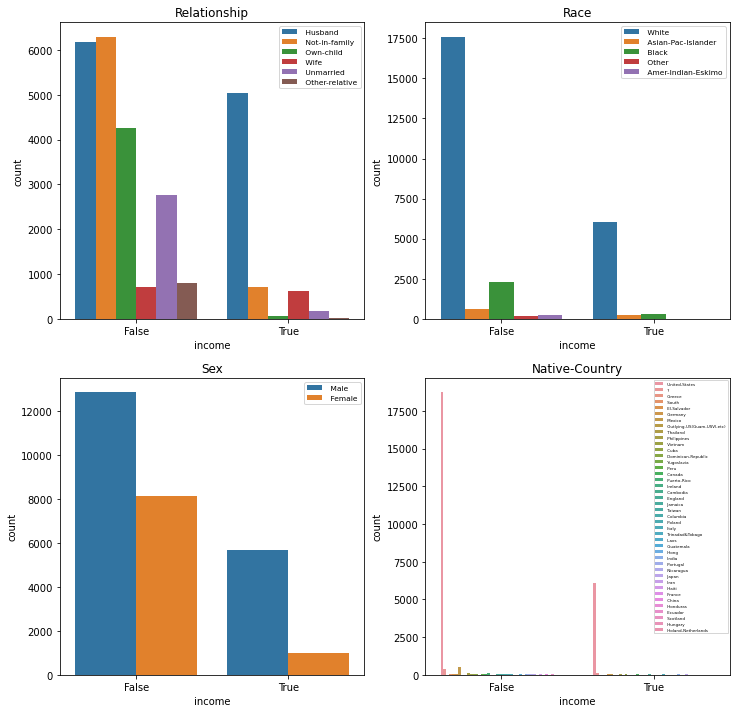

In [38]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
plot1=sns.countplot(x='income', hue='relationship', data=df_temp, ax=ax[0,0])
plot1.legend(loc='upper right',fontsize = 7.5)
plot1.set_title('Relationship')
plot2=sns.countplot(x='income', hue='race', data=df_temp, ax=ax[0,1])
plot2.legend(fontsize = 7.5, loc='upper right')
plot2.set_title('Race')
plot3=sns.countplot(x='income', hue='sex', data=df_temp, ax=ax[1,0])
plot3.legend(loc='upper right', fontsize = 7.5)
plot3.set_title('Sex')
plot4=sns.countplot(x='income', hue='native-country', data=df_temp, ax=ax[1,1])
plot4.legend(fontsize = 4, loc='upper right')
plot4.set_title('Native-Country')

What is immediately obvious is that, being a white, male, husband correlates the most to having a >$50K salary. These relationships will be looked at in more detail during dimensionality reduction.
What is also clear is that the vast majority of respondents were originall from United States

### 1.5 Data Preprocessing pt. 2
It's time to one-hot encode our data

In [40]:
#Use this for faster processing. We will be analyzing the columns however, so we will transform back to a dataframe.
def ohe_to_array(df):
    col_transformer_min_max=ColumnTransformer([('one_hot', OneHotEncoder(), list_objs), #Run OHE on categorical variables only
                                                ('min_max', StandardScaler(), list_nums)])
    sparse_arr=col_transformer_min_max.fit_transform(df)
    train_data=sparse_arr.toarray()
    return train_data

In [43]:
def ohe_to_df(X_train, X_test):
    global list_objs, list_nums
    list_nums=[column for column in X_train.columns if X_train[column].dtype==np.dtype('int')]
    list_objs=[column for column in X_train.columns if X_train[column].dtype==np.dtype('O')]
    ohe=OneHotEncoder()
    arr1_sparse=ohe.fit_transform(X_train[list_objs])
    arr2_sparse=ohe.transform(X_test[list_objs])
    arr1=arr1_sparse.toarray()
    arr2=arr2_sparse.toarray()
    df1=pd.DataFrame(arr1, columns=ohe.get_feature_names())
    df2=pd.DataFrame(arr2, columns=ohe.get_feature_names())
    X_train=pd.merge(df1,X_train[list_nums], left_index=True, right_index=True)
    X_test=pd.merge(df2,X_test[list_nums], left_index=True, right_index=True)
    return X_train, X_test

X_train, X_test=ohe_to_df(X_train,X_test)
X_train.iloc[0:3]

,x0_ ?,x0_ Federal-gov,x0_ Local-gov,x0_ Never-worked,x0_ Private,x0_ Self-emp-inc,x0_ Self-emp-not-inc,x0_ State-gov,x0_ Without-pay,x1_ 10th,...,x7_ Trinadad&Tobago,x7_ United-States,x7_ Vietnam,x7_ Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,59,160662,9,2407,0,60
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,50,209320,13,0,0,40
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,47,228372,14,0,0,48


As you can tell, the columns have very strange names so I built a function to transform the names such that the (n-1) x value is switched with the previous column name in the nth position

In [44]:
def rename_columns(X_train, X_test):
    for i in X_train.columns:
        if len(i.split('_'))>1:
            try:
                index=int(i.split('_')[0][-1])
                X_train.rename(columns= { i : '{}_'.format(list_objs[index]) + i.split('_')[-1]} ,inplace=True)
                X_test.rename(columns= { i : '{}_'.format(list_objs[index]) + i.split('_')[-1]} ,inplace=True)
            except Exception as x:
                print(x)

rename_columns(X_train, X_test)
X_train.iloc[:3]

,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_ 10th,...,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,59,160662,9,2407,0,60
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,50,209320,13,0,0,40
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,47,228372,14,0,0,48


## 2.0: Dimensionality reduction and Data analysis
Let's first compare the income variable with every feature by using correlation, and then do so using Random forest feature importance, then keep the union of the most important features

First we create a correlation array relative to the target

In [46]:
corr_arr=X_train.corrwith(y_train)

I will now add tuples containing all features that start with a keyword of a column (workclass for example), and the correlation of said feature with the income variable.

In [47]:
dict_index={}
list_keywords=['workclass_','education_','marital-status_', 'occupation_','relationship_','race_','sex_', 'native-country_', 'age','fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week']
for i in list_keywords:
    dict_index[i]=[(ind, round(corr_arr[ind],2)) for ind in corr_arr.index if i in ind]

#### Working Class:
Interestingly enough, whether or not someone is self employed in a corporate entity setting, is the best predictor of whether or not they will be payed more than $50K:

In [49]:
dict_index['workclass_']

[('workclass_ ?', -0.08),
 ('workclass_ Federal-gov', 0.06),
 ('workclass_ Local-gov', 0.03),
 ('workclass_ Never-worked', -0.01),
 ('workclass_ Private', -0.08),
 ('workclass_ Self-emp-inc', 0.14),
 ('workclass_ Self-emp-not-inc', 0.03),
 ('workclass_ State-gov', 0.02),
 ('workclass_ Without-pay', -0.01)]

#### Education:
It's clear that getting a Masters, Bachelors, or Doctorate, is of utmost importance if you want to make a decent wage above 50K. However it appears that getting a Bachelors or Masters is more highly correlated with having a >$50K salary than having a Doctorate

In [50]:
dict_index['education_']

[('education_ 10th', -0.07),
 ('education_ 11th', -0.09),
 ('education_ 12th', -0.05),
 ('education_ 1st-4th', -0.03),
 ('education_ 5th-6th', -0.05),
 ('education_ 7th-8th', -0.06),
 ('education_ 9th', -0.06),
 ('education_ Assoc-acdm', 0.01),
 ('education_ Assoc-voc', 0.01),
 ('education_ Bachelors', 0.18),
 ('education_ Doctorate', 0.13),
 ('education_ HS-grad', -0.13),
 ('education_ Masters', 0.18),
 ('education_ Preschool', -0.02),
 ('education_ Prof-school', 0.16),
 ('education_ Some-college', -0.06)]

#### Relationship:
Perhaps it's good to marry, or perhaps the younger folks who make less money simply are creating a bias in our data. What is surprising, however, is that income is correlated to whether or not your spouse is in the armed forces, a civilian, or if you divorced.

In [51]:
dict_index['marital-status_']

[('marital-status_ Divorced', -0.13),
 ('marital-status_ Married-AF-spouse', 0.01),
 ('marital-status_ Married-civ-spouse', 0.45),
 ('marital-status_ Married-spouse-absent', -0.04),
 ('marital-status_ Never-married', -0.32),
 ('marital-status_ Separated', -0.07),
 ('marital-status_ Widowed', -0.07)]

I'm not going to show the output for the rest, for the sake of keeping the notebook neat, but it's easy to see/verify that:
Being in an executive/managerial position or having a specialty job, being a male in a relationship, being white (has a slight correlation), being from the United States (especially not being from Mexico),
level of education, capital gain/loss, age, and hours worked per week is the most correlated with having a >50K salary. Surprisingly, whether or not you were a male, and whether or not you were currently married to a civilian, had the greatest correlation to the higher salary.

Let's now narrow down which features we think may be of the most importance in making our calculations. Here we attain 24 features

In [61]:
columns_keep=list(corr_arr[abs(corr_arr)>0.1].index) #If they have an absolute value of greater than .1:
print('# features: {}'.format(len(columns_keep)),'\n', columns_keep)

# features: 24 
 ['workclass_ Self-emp-inc', 'education_ Bachelors', 'education_ Doctorate', 'education_ HS-grad', 'education_ Masters', 'education_ Prof-school', 'marital-status_ Divorced', 'marital-status_ Married-civ-spouse', 'marital-status_ Never-married', 'occupation_ Exec-managerial', 'occupation_ Other-service', 'occupation_ Prof-specialty', 'relationship_ Husband', 'relationship_ Not-in-family', 'relationship_ Own-child', 'relationship_ Unmarried', 'relationship_ Wife', 'sex_ Female', 'sex_ Male', 'age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']


## 2.1 Dimensionality Reduction pt.2
I will create a random forest to extract the most important features, and then compare them to the correlation analysis

In [55]:
rnd_features=RandomForestClassifier(n_estimators=300, n_jobs=-1)
rnd_features.fit(X_train, y_train)
feature_importance=rnd_features.feature_importances_
feature_importance_dict=set(zip(X_train.columns, feature_importance))
feature_importance_df=pd.DataFrame().from_dict(feature_importance_dict)
feature_importance_list=list(feature_importance_df.sort_values(1, ascending=False).iloc[:24,0]) #Sort the dataframe by the feature importance and choose the 24 highest (equal to that of correlation analysis)

In [62]:
print(feature_importance_list)

['fnlwgt', 'age', 'capital-gain', 'hours-per-week', 'education-num', 'marital-status_ Married-civ-spouse', 'relationship_ Husband', 'capital-loss', 'marital-status_ Never-married', 'occupation_ Exec-managerial', 'occupation_ Prof-specialty', 'relationship_ Not-in-family', 'education_ Bachelors', 'workclass_ Private', 'sex_ Female', 'relationship_ Wife', 'sex_ Male', 'workclass_ Self-emp-not-inc', 'relationship_ Own-child', 'education_ HS-grad', 'education_ Masters', 'occupation_ Sales', 'occupation_ Other-service', 'occupation_ Craft-repair']


Let's see how many of our features were shared between the correlation analysis and the random forest:

In [69]:
n=0
for i in columns_keep:
    if i in feature_importance_list:
        n+=1
print(n)

19


They seem to agree on the most important features

Now let's add every column value that isn't in the columns_keep class already, from our newly made one:

In [71]:
[columns_keep.append(col) for col in feature_importance_list if col not in columns_keep]

[None, None, None, None, None]

Let's now replace our old sets of data

In [73]:
X_train=X_train[columns_keep]
X_test=X_test[columns_keep]

We have reduced the number of features by 79 (108 to 29)! As we will see, the performance is nearly identical despite having nearly 1/4th of the dimensions

## Classification:
LogisticRegression:

In [36]:
def plt_roc(fpr, tpr, label):
    plt.plot(fpr, tpr, label=label)
    plt.legend()
    plt.title('train set')
    plt.show()

def show_scores(model,X_train,y_train,X_test,y_test):
    y_pred_train=model.predict(X_train)
    y_pred_test=model.predict(X_test)
    print('Accuracy on train set = ',accuracy_score(y_train, y_pred_train))
    print('Recall on train set = ',recall_score(y_train, y_pred_train))
    print('Precision on train set = ',precision_score(y_train, y_pred_train), '\n')
    print('Accuracy on test set = ',accuracy_score(y_test, y_pred_test))
    print('Recall on test set = ',recall_score(y_test, y_pred_test))
    print('Precision on test set = ',precision_score(y_test, y_pred_test,'\n'))

    try:
        y_scores=model.decision_function(X_train)
        fpr,tpr, thresholds=roc_curve(y_pred_train, y_scores)
        label=list(model.best_estimator_.named_steps.keys())[-1]
        plt_roc(fpr, tpr, label)
        print('Area under curve for train set:',round(roc_auc_score(y_train, y_scores),3), 'out of 1')
    except Exception as x:
        print('\n',x)

In [37]:
pipe_logreg=Pipeline([('scaler',MinMaxScaler()), ('logistic_reg', LogisticRegression(max_iter=1000))])
parameters=[{'scaler':[StandardScaler()], 'logistic_reg__penalty':['l2'], 'logistic_reg__C':[1,0.1,1e-2,1e-3] ,'logistic_reg__tol':[1e-5, 1e-4,1e-3]},
            {'scaler':[MinMaxScaler()], 'logistic_reg__penalty':['l2'], 'logistic_reg__C':[1,0.1,1e-2,1e-3] ,'logistic_reg__tol':[1e-5, 1e-4, 1e-3]}]
grid_search_logreg = GridSearchCV( pipe_logreg, parameters, n_jobs=-1)
grid_search_logreg.fit(X_train,y_train)
grid_search_logreg.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logistic_reg',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=1e-05, verbose=0,
                                    warm_start=False))],
         verbose=False)

Accuracy on train set =  0.8490027460615696
Recall on train set =  0.5837959489872468
Precision on train set =  0.7347054380664653 

Accuracy on test set =  0.8491299897645854
Recall on test set =  0.5833333333333334
Precision on test set =  0.7352625937834941


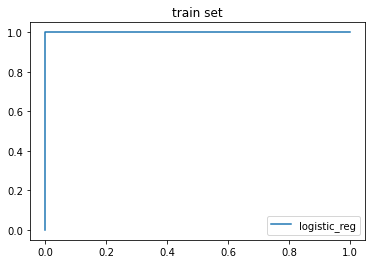

Area under curve for train set: 0.904 out of 1


In [38]:
#As you can tell, it seems that the model is struggling with identifying True positives in such a way that implies that our threshold may be too low.
show_scores(grid_search_logreg, X_train, y_train, X_test, y_test)

.852 acc. score without Dim reduction, and .847 despite nearly 1/5th of the number of features!

## SVCs:

In [39]:
pipe_SVC=Pipeline([('scaler',StandardScaler()),('svc',LinearSVC())])
##We will test between linearSVC and SVC with various kernels besides linear (since it is generally much slower)
parameters_svc=[{'scaler':[StandardScaler()], 'svc':[LinearSVC()], 'svc__penalty':['l2'], 'svc__C':[10,1,1e-1]},
            #{'scaler':[MinMaxScaler()], 'svc':[LinearSVC()], 'svc__penalty':['l2'], 'svc__C':[10,1,1e-1]},
            {'scaler':[StandardScaler()], 'svc':[SVC()], 'svc__kernel':['poly', 'rbf'], 'svc__degree':[2,3], 'svc__C':[10,1,1e-1]},
            #{'scaler':[MinMaxScaler()], 'svc':[SVC()], 'svc__kernel':['poly', 'rbf'], 'svc__degree':[2,3], 'svc__C':[10,1,1e-1]}
            ]
grid_search_SVC=GridSearchCV(pipe_SVC,parameters_svc,n_jobs=-1)
grid_search_SVC.fit(X_train, y_train)
grid_search_SVC.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=2,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [62]:
grid_search_SVC.best_params_

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'svc': SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
     kernel='rbf', max_iter=-1, probability=False, random_state=None,
     shrinking=True, tol=0.001, verbose=False),
 'svc__C': 1,
 'svc__degree': 2,
 'svc__kernel': 'rbf'}

Accuracy on train set =  0.8603121838415956
Recall on train set =  0.6019504876219055
Precision on train set =  0.7678468899521531 

Accuracy on test set =  0.8528147389969294
Recall on test set =  0.5790816326530612
Precision on test set =  0.7524861878453039


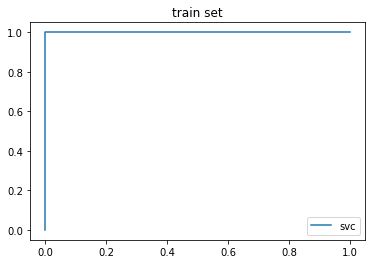

Area under curve for train set: 0.912 out of 1


In [40]:
show_scores(grid_search_SVC, X_train, y_train, X_test, y_test)

## Decision Tree

In [45]:
d_tree=DecisionTreeClassifier(criterion='gini', min_samples_split=50)
d_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [46]:
#Decision tree has the best results so far, but it appears like it may overfit significantly
show_scores(d_tree, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8932287902876138
Recall on train set =  0.7156789197299325
Precision on train set =  0.8181818181818182 

Accuracy on test set =  0.8479017400204708
Recall on test set =  0.6258503401360545
Precision on test set =  0.7083734359961501

 'DecisionTreeClassifier' object has no attribute 'decision_function'


# Ensemble Learning
## Random Forests:

In [47]:
rnd_fc=RandomForestClassifier(n_estimators=250, min_samples_split=20,n_jobs=-1)
rnd_fc.fit(X_train, y_train)
show_scores(rnd_fc, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.9090547767018355
Recall on train set =  0.7252813203300825
Precision on train set =  0.8757246376811594 

Accuracy on test set =  0.8632548618219038
Recall on test set =  0.6147959183673469
Precision on test set =  0.7707889125799574

 'RandomForestClassifier' object has no attribute 'decision_function'


In [48]:
#The rnd_clf implies that the most important factors in determining whether or not you will make over $50K per year are your age, education, capital gain, and whether or not you are a husband in a healthy marriage!!!
set(zip(X_train.columns,rnd_fc.feature_importances_))

{('age', 0.10656534172973489),
 ('capital-gain', 0.16020242527700126),
 ('capital-loss', 0.046412737879125296),
 ('education-num', 0.11655541723198992),
 ('education_ Bachelors', 0.015249273315979622),
 ('education_ Doctorate', 0.0038719037455817538),
 ('education_ HS-grad', 0.008439412780837078),
 ('education_ Masters', 0.009001476110363862),
 ('education_ Prof-school', 0.005115105689382539),
 ('fnlwgt', 0.08089520366248962),
 ('hours-per-week', 0.0701256335686982),
 ('marital-status_ Divorced', 0.004632871674213661),
 ('marital-status_ Married-civ-spouse', 0.12491467827350258),
 ('marital-status_ Never-married', 0.029871482677960803),
 ('occupation_ Craft-repair', 0.005264049928186244),
 ('occupation_ Exec-managerial', 0.02457533566569607),
 ('occupation_ Other-service', 0.007360992602199075),
 ('occupation_ Prof-specialty', 0.019250248644675623),
 ('occupation_ Sales', 0.006447930746530806),
 ('relationship_ Husband', 0.0819085882921393),
 ('relationship_ Not-in-family', 0.008570291

## Voting classification:

In [63]:
# Let's use the best params from our grid search to build an SVC that can predict probabilities of an instance belonging to the positive class
#The scores are identical to the previous grid search with SVC
pipe_SVC_prob=Pipeline([('scaler',StandardScaler()),('svc',SVC(degree=2, C=1, kernel='rbf', probability=True))])
pipe_SVC_prob.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=2,
                     gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                     probability=True, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [28]:
#Surprisingly, the voting classifier actually underperforms the plain rbf kernel SVC!
voting_clf_soft=VotingClassifier(estimators=[('lr',grid_search_logreg), ('svc', pipe_SVC_prob)], voting='soft')
voting_clf_soft.fit(X_train, y_train)
show_scores(voting_clf_soft, X_train, y_train, X_test, y_test)

KeyboardInterrupt: 

In [ ]:
#The Random Forest Classifier still outperforms this classifier
voting_clf_hard=VotingClassifier(estimators=[('lr',grid_search_logreg), ('svc', pipe_SVC_prob), ('rfc', rnd_fc)], voting='hard')
voting_clf_hard.fit(X_train, y_train)
show_scores(voting_clf_hard, X_train, y_train, X_test, y_test)

## Bagging Clf:

In [ ]:
#We were able to extract a performance boost while using a bagging classifier vs the plain decision Tree clf!
bg_clf=BaggingClassifier(DecisionTreeClassifier(criterion='gini', min_samples_split=25), n_estimators=300, max_samples=X_train.shape[0], n_jobs=-1, bootstrap=True)
bg_clf.fit(X_train, y_train)
show_scores(bg_clf, X_train, y_train, X_test, y_test)

## Gradient Boosting

In [49]:
#It is surprisingly hard to overfit this classifier
gb_clf=GradientBoostingClassifier(n_estimators=600, random_state=1)
gb_clf.fit(X_train, y_train)
show_scores(gb_clf, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.88639976875271
Recall on train set =  0.6756189047261816
Precision on train set =  0.8209662716499544 

Accuracy on test set =  0.8696008188331628
Recall on test set =  0.6437074829931972
Precision on test set =  0.7764102564102564

 'GradientBoostingClassifier' object has no attribute 'best_estimator_'


## Stacking:

In [201]:
stacking_clf=StackingClassifier(estimators=[('log_reg', grid_search_logreg),
                                            ('svc_rbf', grid_search_SVC),
                                            ('dec_tree',d_tree),
                                            ('random_forest', rnd_fc),
                                            ('grad_boosting', gb_clf)],
                                            final_estimator=LogisticRegression(), n_jobs=-1, verbose=2)
stacking_clf.fit(X_train, y_train)
show_scores(stacking_clf, X_train, y_train, X_test, y_test)

Accuracy on train set =  0.8789564966035555
Recall on train set =  0.65536384096024
Precision on train set =  0.8057553956834532 

Accuracy on test set =  0.8630501535312181
Recall on test set =  0.6190476190476191
Precision on test set =  0.7671232876712328

 'StackingClassifier' object has no attribute 'best_estimator_'


# Stacking with Neural Network:

In [50]:
import tensorflow as tf
from tensorflow import keras

In [57]:
X_train_nn, X_valid_nn, y_train_nn, y_valid_nn = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [58]:
y_train_nn.reset_index(drop=True, inplace=True)
y_valid_nn.reset_index(drop=True, inplace=True)

In [64]:
def create_df_4_NN(df):
    df_NN=pd.DataFrame(grid_search_logreg.predict_proba(df)[:,0])
    for model in [pipe_SVC_prob, d_tree, rnd_fc, gb_clf]:
        if hasattr(model, 'predict_proba'):
            df_temp=pd.DataFrame(model.predict_proba(df)[:,0])
        else:
            df_temp=pd.DataFrame(model.predict(df))
        df_NN=pd.merge(df_NN,df_temp, right_index=True, left_index=True)
    return df_NN

In [65]:
X_train_nn=create_df_4_NN(X_train_nn)
X_train_nn=pd.merge(X_train_nn, y_train_nn, left_index=True, right_index=True)
X_train_nn.to_csv('training_set_NN')

X_valid_nn=create_df_4_NN(X_valid_nn)
X_valid_nn=pd.merge(X_valid_nn, y_valid_nn, left_index=True, right_index=True)
X_valid_nn.to_csv('validation_set_NN')

X_test_nn=create_df_4_NN(X_test)
X_test_nn=pd.merge(X_test_nn, y_test, left_index=True, right_index=True)
X_test_nn.to_csv('test_set_NN')

In [129]:
def read_df():
    train_nn = pd.read_csv('training_set_NN', index_col=0)
    valid_nn = pd.read_csv('validation_set_NN', index_col=0)
    test_nn = pd.read_csv('test_set_NN', index_col=0)
    X_train_nn = np.array(train_nn.loc[:,:'0'])
    y_train_nn = train_nn['income']
    X_valid_nn = np.array(valid_nn.loc[:,:'0'])
    y_valid_nn = valid_nn['income']
    X_test_nn = np.array(test_nn.loc[:,:'0'])
    y_test_nn = test_nn['income']
    return X_train_nn, X_valid_nn, X_test_nn, y_train_nn, y_valid_nn, y_test_nn

In [130]:
X_train_nn, X_valid_nn, X_test_nn, y_train_nn, y_valid_nn, y_test_nn = read_df()

In [131]:
y_train_nn=np.array(y_train_nn*1)
y_valid_nn=np.array(y_valid_nn*1)
y_test_nn=np.array(y_test_nn*1)

In [132]:
y_train_nn[0:5]

array([1, 0, 0, 0, 0])

In [157]:
now=datetime.now()
callbacks=[keras.callbacks.EarlyStopping(restore_best_weights=True, patience=7)]
#optimizer=keras.optimizers.Adam()
metric = tf.keras.metrics.Recall()
nn_model=keras.models.Sequential([keras.Input(shape=(5,))])
for i in range(6):
    nn_model.add(keras.layers.BatchNormalization())
    keras.layers.Dropout(rate=0.1)
    nn_model.add(keras.layers.Dense(60, activation='elu', kernel_initializer='he_normal'))
nn_model.add(keras.layers.Dense(1, activation='sigmoid'))

nn_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=[metric])
hist=nn_model.fit(X_train_nn, y_train_nn, epochs=45, validation_data=(X_valid_nn, y_valid_nn))
print(datetime.now()-now)

Train on 22140 samples, validate on 5536 samples
Epoch 1/45
22140/22140 [==============================] - 11s 510us/sample - loss: 0.1974 - recall_3: 0.8500 - val_loss: 0.1512 - val_recall_3: 0.8515
Epoch 2/45
22140/22140 [==============================] - 9s 407us/sample - loss: 0.1620 - recall_3: 0.8485 - val_loss: 0.1436 - val_recall_3: 0.8845
Epoch 3/45
22140/22140 [==============================] - 8s 380us/sample - loss: 0.1573 - recall_3: 0.8586 - val_loss: 0.1414 - val_recall_3: 0.8897
Epoch 4/45
22140/22140 [==============================] - 9s 388us/sample - loss: 0.1550 - recall_3: 0.8582 - val_loss: 0.1424 - val_recall_3: 0.8575
Epoch 5/45
22140/22140 [==============================] - 9s 388us/sample - loss: 0.1517 - recall_3: 0.8644 - val_loss: 0.1401 - val_recall_3: 0.8882
Epoch 6/45
22140/22140 [==============================] - 9s 392us/sample - loss: 0.1514 - recall_3: 0.8650 - val_loss: 0.1426 - val_recall_3: 0.8957
Epoch 7/45
22140/22140 [==========================

In [149]:
nn_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_10 (Batc (None, 5)                 20        
_________________________________________________________________
dense_14 (Dense)             (None, 10)                60        
_________________________________________________________________
batch_normalization_11 (Batc (None, 10)                40        
_________________________________________________________________
dense_15 (Dense)             (None, 10)                110       
_________________________________________________________________
batch_normalization_12 (Batc (None, 10)                40        
_________________________________________________________________
dense_16 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_17 (Dense)             (None, 1)                

In [150]:
def show_scores_nn(model,X_train,y_train,X_test,y_test, X_valid, y_valid):
    y_pred_train=(nn_model.predict(X_train)>=.5)*1
    y_pred_test=(nn_model.predict(X_test)>=.5)*1
    y_pred_valid=(nn_model.predict(X_valid)>=.5)*1
    print('Accuracy on train set = ',accuracy_score(y_train, y_pred_train))
    print('Recall on train set = ',recall_score(y_train, y_pred_train))
    print('Precision on train set = ',precision_score(y_train, y_pred_train), '\n')
    print('Accuracy on val. set = ',accuracy_score(y_valid, y_pred_valid))
    print('Recall on val. set = ',recall_score(y_valid, y_pred_valid))
    print('Precision on val. set = ',precision_score(y_valid, y_pred_valid), '\n')
    print('Accuracy on test set = ',accuracy_score(y_test, y_pred_test))
    print('Recall on test set = ',recall_score(y_test, y_pred_test))
    print('Precision on test set = ',precision_score(y_test, y_pred_test))

In [158]:
#With dropout
show_scores_nn(nn_model, X_train_nn, y_train_nn, X_test_nn, y_test_nn, X_valid_nn, y_valid_nn)

Accuracy on train set =  0.9447606142728094
Recall on train set =  0.913728432108027
Precision on train set =  0.8645962732919255 

Accuracy on val. set =  0.9420158959537572
Recall on val. set =  0.90847711927982
Precision on val. set =  0.8588652482269503 

Accuracy on test set =  0.836028659160696
Recall on test set =  0.6675170068027211
Precision on test set =  0.6569037656903766


In [140]:
y_pred_train=(nn_model.predict(X_train_nn)>=.5)*1

In [141]:
y_pred_train

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])